In [1]:
import numpy as np
import tensorflow as tf
import os
import zipfile
import shutil
import cv2
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
from PIL import Image
from tensorflow.python.framework import ops
import math
import glob
from shutil import copyfile
import pandas as pd

# import seaborn as sns

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
id='1pOa0wYI0q0z7-XuWnYwBrO3io-J6bgFM'
id2='1Io_ZfD4ARm-vRBJoRURZ8d_lPkEbx6YU'

In [105]:
downloaded = drive.CreateFile({'id':id})  #drive from PyDrive
downloaded.GetContentFile('cassava-disease.zip')

In [109]:
local_zip='./cassava-disease.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/')
zip_ref.close()

In [114]:
list_directory=os.listdir('./data/train/')
print(list_directory)

['healthy', 'cbb', 'cmd']


healthy


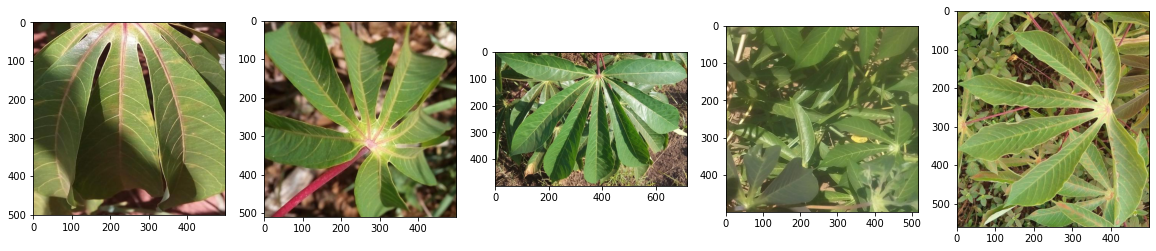

cbb


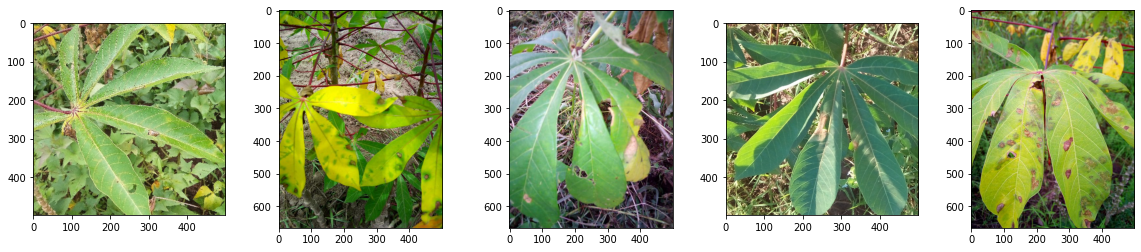

cmd


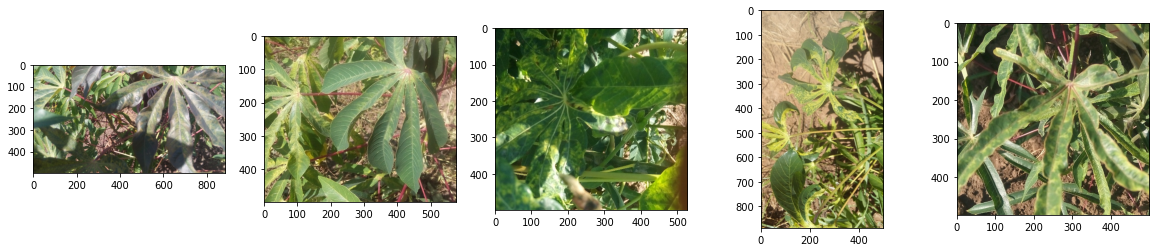

In [115]:
#checking image on directory
imdir='./data/train/'
for  images in list_directory:
  print(images)
  class_dir = os.path.join(imdir,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

In [116]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D

In [117]:
findir='./siuu/train/'

# Image preprocessing

In [121]:
image_size=128
datagen = tf.keras.preprocessing.image.ImageDataGenerator( # rotation
      
           
            rescale=1/255,
            validation_split=0.2,)
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2   
)
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator()
batch_size = 70
train_generator = train_datagen.flow_from_directory(
    imdir,
    target_size =(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    imdir,
    target_size = (image_size,image_size),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation'
)

Found 1354 images belonging to 3 classes.
Found 338 images belonging to 3 classes.


In [122]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['cbb', 'cmd', 'healthy']

In [123]:
train_generator.class_indices

{'cbb': 0, 'cmd': 1, 'healthy': 2}

In [124]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.82 and logs.get('val_accuracy')>0.82):
      self.model.stop_training = True
      print("\nThe accuracy of the training set and the validation set has reached > 85%!")
callbacks = myCallback()

In [125]:
base_model = tf.keras.applications.MobileNetV2(include_top=False,weights='imagenet',input_shape=(image_size,image_size,3))
base_model.trainable = False

In [127]:
try:
    with tf.device('/device:GPU:0'):
        inputs = tf.keras.layers.Input(shape=(image_size,image_size,3))
        x = base_model(inputs)
        x = tf.keras.layers.GaussianNoise(0.2)(x)
        # x=tf.keras.layers.Dropout(0.5)(x)
       
        
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        outputs = tf.keras.layers.Dense(3,activation="softmax")(x)

        model4 = tf.keras.Model(inputs=[inputs],outputs=[outputs])

        model4.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
                      loss='categorical_crossentropy',
                      #loss=tfa.losses.SigmoidFocalCrossEntropy(),
                      metrics=['accuracy'])

        history=model4.fit(train_generator,epochs=30,validation_data=validation_generator,callbacks=callbacks
                           )
except RuntimeError as e:
    print(e)   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/30
20/20 [==============================] - 18s 794ms/step - loss: 1.0955 - accuracy: 0.5369 - val_loss: 0.8596 - val_accuracy: 0.6095
Epoch 2/30
20/20 [==============================] - 14s 713ms/step - loss: 0.6760 - accuracy: 0.7068 - val_loss: 0.6423 - val_accuracy: 0.7278
Epoch 3/30
20/20 [==============================] - 14s 709ms/step - loss: 0.5925 - accuracy: 0.7585 - val_loss: 0.5741 - val_accuracy: 0.7663
Epoch 4/30
20/20 [==============================] - 14s 707ms/step - loss: 0.5677 - accuracy: 0.7696 - val_loss: 0.5426 - val_accuracy: 0.7929
Epoch 5/30
20/20 [==============================] - 15s 780ms/step - loss: 0.5319 - accuracy: 0.7866 - val_loss: 0.5476 - val_accuracy: 0.7929
Epoch 6/30
20/20 [==============================] - 15s 703ms/step - loss: 0.5117 - accuracy: 0.7969 - val_loss: 0.5193 - val_accuracy: 0.8047
Epoch 7/30
20/20 [==============================] - 14s 715ms/step - loss: 0.4987 - accuracy: 0.8124 - val_loss: 0.4976 - val_accuracy: 0.8077

In [128]:
score_train = model4.evaluate(train_generator)
score_valid = model4.evaluate(validation_generator)

print('Accuracy (train): ', score_train[1])
print('Accuracy: (test)', score_valid[1])

5/5 [==============================] - 2s 383ms/step - loss: 0.4635 - accuracy: 0.8314
Accuracy (train):  0.8286558389663696
Accuracy: (test) 0.831360936164856


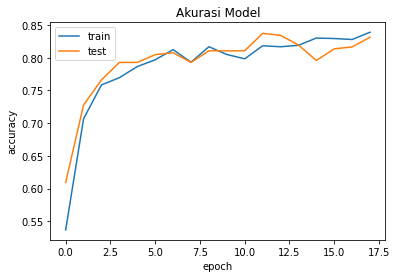

In [129]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')

plt.show()

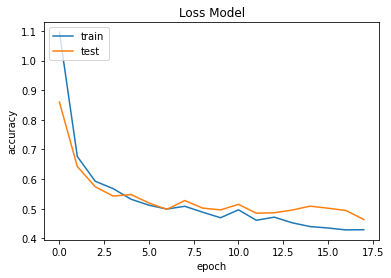

In [130]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save Model

In [ ]:
import tempfile
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

model4.save(export_path, save_format="tf")

print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


Already saved a model, cleaning up

INFO:tensorflow:Assets written to: /tmp/1/assets


INFO:tensorflow:Assets written to: /tmp/1/assets



export_path = /tmp/1
total 3616
drwxr-xr-x 2 root root    4096 May 15 12:42 assets
-rw-r--r-- 1 root root  529186 May 15 12:42 keras_metadata.pb
-rw-r--r-- 1 root root 3160255 May 15 12:42 saved_model.pb
drwxr-xr-x 2 root root    4096 May 15 12:42 variables


In [ ]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(export_path)

# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

# Use the tool to finally convert the model
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = 'cassava_disease_v2_m3.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

with open('cassava_disease_v3.txt', 'w') as f:
    f.write('\n'.join(label_types))

Saving Cassava-Bacterial-Blight-20.png to Cassava-Bacterial-Blight-20 (2).png
Cassava Bacterial Blight


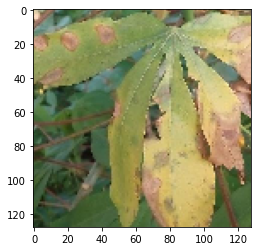

In [ ]:
from google.colab import files
from keras.preprocessing import image
 
uploaded = files.upload()
 
for path in uploaded.keys():
  img = image.load_img(path, target_size=(image_size,image_size))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  images /= 255 # because on train and test image is normalized, on image predict supposed to be too.
  classes = model4.predict(images, batch_size=100) # the value is not always 1 and 0 because of probabilities
  predicted_class_indices=np.argmax(classes) # use to check prediction that have higher probabilities

if predicted_class_indices == 0:
    print('Cassava Bacterial Blight')

elif predicted_class_indices == 1:
  print('Cassava Green Mottle')
elif predicted_class_indices == 2:
  print('cassava mosaic disease ')
elif predicted_class_indices == 3:
  print('Healthy')
else:
  print('')

# Model 2

In [4]:
downloaded2= drive.CreateFile({'id':id2})  #drive from PyDrive
downloaded2.GetContentFile('data.zip')

In [5]:
local_zip='./data.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./dataset_siap/')
zip_ref.close()

In [6]:
list_directory=os.listdir('./dataset_siap/train/')
print(list_directory)
imdir='./dataset_siap/train/'

['healthy', 'cbsd', 'cbb', 'cmd']


In [7]:
diseases=('cbb','cbsd','cmd','healthy')

In [8]:
def load_image_array(alldata_dir, disease):
  temp_dis_dir = os.path.join(imdir, disease)
  temp_files = os.listdir(temp_dis_dir)
  temp_paths = [os.path.join(temp_dis_dir, file) for file in temp_files]
  temp_imgs = [read_image(file) for file in temp_paths]

  return np.array(temp_imgs)

def image_pixel_normalization(image):
  """
  transform image to same size without cropping the image
  e.g. image size : (200, 600) => (600, 600)
  """
  h, w, _ = image.shape

  norm_size = h if h > w else w
  
  add_h = norm_size - h
  add_w = norm_size - w 
  
  start_add_h = add_h // 2
  start_add_w = add_w // 2

  new_img = np.full((norm_size, norm_size, 3), 255, dtype=np.uint8)
  new_img[start_add_h:start_add_h + h, start_add_w:start_add_w + w, :] = image
  
  return new_img

def preprocessing(image):
  """
  preprocessing image including size normalization and resize image
  """
  img = image_pixel_normalization(image)
  img = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
  return np.array(img)

def read_image(image_file):
  img = cv2.imread(image_file)
  img = preprocessing(img)
  return np.array(img)

In [9]:
disease_imgs = {}

for disease in diseases:
  disease_imgs[disease] = load_image_array(imdir, disease)
  print(disease, "done") 

disease_imgs.keys()

cbb done
cbsd done
cmd done
healthy done


dict_keys(['cbb', 'cbsd', 'cmd', 'healthy'])

In [10]:
disease_imgs['cbb'].shape

(466, 300, 300, 3)

In [15]:
shutil.rmtree('siuu/train', ignore_errors=True)
finaldata_dir = "./siuu/train/"

In [17]:
os.mkdir(finaldata_dir)
for disease in diseases:
  os.mkdir(os.path.join(finaldata_dir, disease))

FileExistsError: ignored

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, Flatten, MaxPool2D

In [19]:
datagen = ImageDataGenerator(
            rotation_range=25, # rotation
            width_shift_range=0.15, # horizontal shift
            height_shift_range=0.15, # vertical shift
            zoom_range=0.1, # zoom
            horizontal_flip=True, # horizontal flip
            vertical_flip=True, # vertical flip
            brightness_range=[0.75,1.25], # brightness
          )

def generate_image(datagen, data, amount, savepath=None):
  # prepare iterator
  it = datagen.flow(
        data, 
        batch_size=1, 
        save_to_dir=savepath,
        save_prefix='',
        save_format='png',
      )
  
  # generate samples and plot
  for i in range(amount):
    batch = it.next()
    image = batch[0].astype('uint8')

In [51]:
amount = 1000

for idx, disease in enumerate(diseases):
  save_path = os.path.join(finaldata_dir, disease)
  generate_image(datagen, disease_imgs[disease], amount, save_path)
  print("{} (done) : {}".format(disease, len(os.listdir(save_path))))

cbb (done) : 1700
cbsd (done) : 1700
cmd (done) : 1700
healthy (done) : 1699


In [52]:
!zip -r finaldata.zip siuu/train/

Streaming output truncated to the last 5000 lines.
updating: siuu/train/cbb/_10_782.png (deflated 0%)
updating: siuu/train/cbb/_137_8036.png (deflated 0%)
updating: siuu/train/cbb/_393_3785.png (deflated 0%)
updating: siuu/train/cbb/_415_8113.png (deflated 0%)
updating: siuu/train/cbb/_264_8895.png (deflated 0%)
updating: siuu/train/cbb/_90_4007.png (deflated 0%)
updating: siuu/train/cbb/_73_7811.png (deflated 0%)
updating: siuu/train/cbb/_137_1531.png (deflated 0%)
updating: siuu/train/cbb/_270_9109.png (deflated 0%)
updating: siuu/train/cbb/_41_1306.png (deflated 0%)
updating: siuu/train/cbb/_419_7790.png (deflated 0%)
updating: siuu/train/cbb/_416_2413.png (deflated 0%)
updating: siuu/train/cbb/_195_3142.png (deflated 0%)
updating: siuu/train/cbb/_251_5191.png (deflated 0%)
updating: siuu/train/cbb/_188_4514.png (deflated 0%)
updating: siuu/train/cbb/_102_1592.png (deflated 0%)
updating: siuu/train/cbb/_52_8686.png (deflated 0%)
updating: siuu/train/cbb/_269_2718.png (deflated 0%)
u

healthy


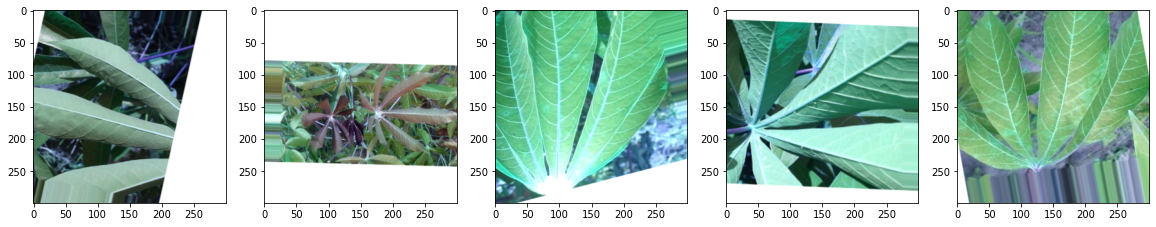

cbsd


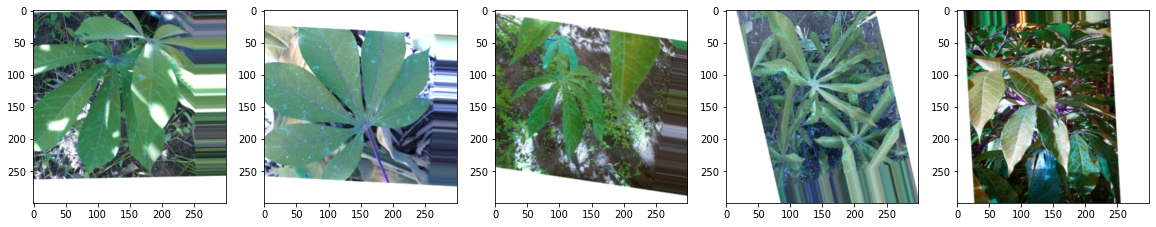

cbb


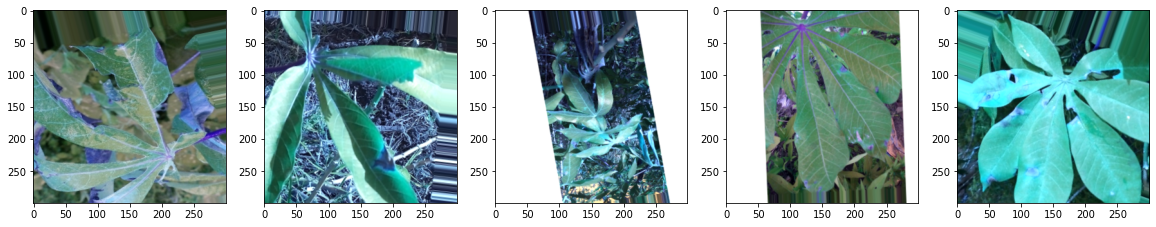

cmd


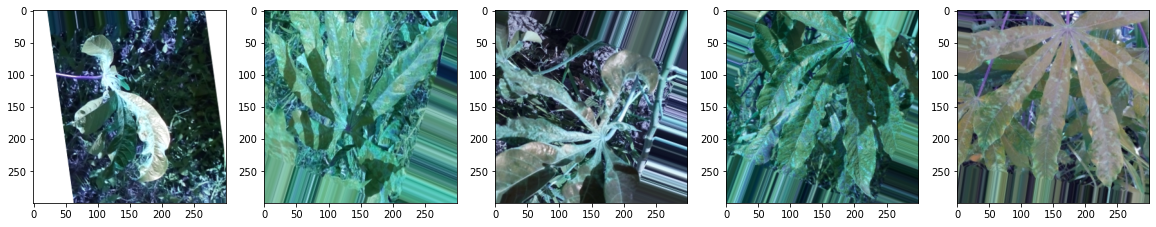

In [24]:
#checking image on directory
findir='./siuu/train/'
for  images in list_directory:
  print(images)
  class_dir = os.path.join(findir,images)
  class_images = os.listdir(class_dir)
  plt.figure(figsize=(20, 4))
  for i, img_path in enumerate(class_images[:5]):
    sp = plt.subplot(1, 5, i+1)
    img = mpimg.imread(os.path.join(class_dir, img_path))
    plt.imshow(img)
  plt.show()

In [102]:
image_shape=150
datagen = ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.2 
)

batch_size = 100
train_generator = datagen.flow_from_directory(
    imdir,
    target_size =(150,150),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    imdir,
    target_size = (150,150),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='validation',
    shuffle=False
)

Found 3908 images belonging to 4 classes.
Found 975 images belonging to 4 classes.


In [27]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),  
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 17, 17, 64)       0

In [28]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [29]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      self.model.stop_training = True
      print("\nThe accuracy of the training set has reached > 99%!")
callbacks = myCallback()

In [103]:
# fitting model
history = model.fit(
    train_generator,
    epochs = 35,
    validation_data = validation_generator,
    verbose = 1,
    callbacks=[callbacks]
)

Epoch 1/35


InvalidArgumentError: ignored

In [99]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),  
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  
])


In [100]:
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    # YOUR CODE HERE: Add loss and metric
    loss= tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'],) 

In [104]:
history=model3.fit(train_generator,validation_data=validation_generator,epochs=30,callbacks=callbacks)

Epoch 1/30


InvalidArgumentError: ignored

In [96]:
import tensorflow as tf
model4 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(64, (3,3),padding='same',activation='relu', input_shape=(image_size,image_size, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),    
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  
])

In [97]:

model4.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001,decay=1e-6),
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              #loss=tfa.losses.SigmoidFocalCrossEntropy(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [98]:
history=model4.fit(train_generator,validation_data=validation_generator,epochs=30,callbacks=callbacks)

Epoch 1/30
78/78 [==============================] - 45s 574ms/step - loss: 1.4555 - accuracy: 0.3013 - val_loss: 1.3108 - val_accuracy: 0.3149
Epoch 2/30
78/78 [==============================] - 48s 618ms/step - loss: 1.3404 - accuracy: 0.3710 - val_loss: 1.2332 - val_accuracy: 0.4202
Epoch 3/30
17/78 [=====>........................] - ETA: 30s - loss: 1.3254 - accuracy: 0.3857

KeyboardInterrupt: ignored